<a href="https://colab.research.google.com/github/meichenfang/explicit-trajectory/blob/main/uniform-prior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Denote the gene expression matrix by $X_{ij}$ where j is gene index and i is cell index. In summary, we assume a specific model of transcription and want to solve**

\begin{align}
    & \text{argmax}_{\theta_j} \sum_{j} \sum_i \ln P(\mathcal{X}_{ij},t_i; \theta_j,\tau).
\end{align}

We assume t follows a uniform distribution on [0,1]. We use alternative minimization/EM-like algorithm to find optimal θ.

In [1]:
!git clone https://github.com/meichenfang/explicit-trajectory.git

Cloning into 'explicit-trajectory'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 3), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.


In [5]:
!mv explicit-trajectory/* .

In [4]:
from EM_functions import *
from order_functions import *
import time

In [61]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 16 21:20:50 2022

@author: Meichen Fang
"""

import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def get_Y(theta, t, tau):
    # theta: p*(K+4)
    # t: len m
    # tau: len K+1
    # return m * p * 2
    eps = 10**(-6)
    p = len(theta)
    K = len(tau)-1 # number of states
    if np.shape(theta)[1]!=K+4:
      raise TypeError("wrong parameters lengths")
    a = theta[:,0:K]
    beta = theta[:,-2]
    gamma = theta[:,-1]

    y1_0 = theta[:,-4]
    y2_0 = theta[:,-3]

    c = beta/(beta-gamma+eps)
    d = beta**2/((beta-gamma)*gamma+eps)
    y_0 = y2_0 + c*y1_0
    a_ = d[:,None]*a
    t = t.reshape(-1,1)
    m = len(t)
  
    I = np.ones((K+1,m),dtype=bool)
    y1 =np.zeros((m,p))
    y =np.zeros((m,p))

    # nascent
    y1=y1+y1_0[None,:]*np.exp(-beta[None,:]*t)   
    for k in range(1,K+1):
      I[k] = np.squeeze(t > tau[k])
      idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
      y1 = y1 + I[k,:,None] * a[None,:,k-1] * (np.exp(-beta[None,:]*(t-tau[k]))- np.exp(-beta[None,:]*(t-tau[k-1])) ) \
          + idx[:,None] * a[None,:,k-1] * (1 - np.exp(-beta[None,:]*(t-tau[k-1]))) 
      
    # mature + c * nascent 
    y=y+y_0[None,:]*np.exp(-gamma[None,:]*t)    
    for k in range(1,K+1):
      idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
      y = y + I[k,:,None] * a_[None,:,k-1] * (np.exp(-gamma[None,:]*(t-tau[k]))- np.exp(-gamma[None,:]*(t-tau[k-1])) ) \
          + idx[:,None] * a_[None,:,k-1] * (1 - np.exp(-gamma[None,:]*(t-tau[k-1]))) 

    Y =np.zeros((m,p,2))
    Y[:,:,0] = y1
    Y[:,:,1] = y-c*y1
    return Y



def neglogL(theta,x,weight,t,tau):
    # theta: length K+4
    # x: n*2
    # weight: n*m
    # t: len m
    # tau: len K+1
    eps = 10**(-6)
    Y = get_Y(theta[None,:],t,tau) # m*1*2
    Y = Y[None,:,0,:] # 1*m*2
    logL = np.sum( weight[:,:,None] * (x[:,None,:] * np.log( eps + Y) - Y ) )  
    return - logL
    
def minimize_wrapper(args):
    theta0, x, weight, t, tau, bounds = args
    res = minimize(neglogL, theta0, args=(x,weight,t,tau), bounds=bounds, options={'maxiter':100000,'disp': True}) 
    return res.x

def update_theta(X,weight,tau,parallel=False,n_threads=1,theta0=None):
    eps = 10**(-6)
    n,p,s=np.shape(X)
    if s!=2:
      raise TypeError("wrong parameters lengths")
    n,m=np.shape(weight)
    t=np.linspace(0,1,m)
    K=len(tau)-1
    bounds = ([[0, np.inf]]*(K+4))
    if theta0 is None:
        theta0 = np.ones((p,K+4))
        theta0[:,0:(K+2)]=np.mean(X[:,:,0],axis=0)[:,None]
        gamma_hat = np.mean(X[:,:,0],axis=0)/(np.mean(X[:,:,1],axis=0)+eps)
        theta0[:,-1] = gamma_hat

    if parallel is True:
        Input_args = []
        for i in range(p):
            Input_args.append((theta0[i], X[:,i], weight, t, tau, bounds))
        with Pool(n_threads) as pool:      
            theta_hat = pool.map(minimize_wrapper, Input_args)
        theta_hat = np.array(theta_hat)
    else:
        theta_hat = np.zeros((p,K+4))
        for i in range(p):  
          res = minimize(neglogL, theta0[i], args=(X[:,i],weight,t,tau), bounds=bounds, options={'maxiter':10000,'disp': True}) 
          theta_hat[i,:] = res.x
    return theta_hat

def update_weight(X,theta,tau,m):
    n,p,s=np.shape(X)
    t=np.linspace(0,1,m)
    eps = 10**(-50)
    Y = get_Y(theta,t,tau) # m*p*2
    Y = Y[None,:,:,:] # 1*m*p*2
    logL =  np.sum(X[:,None,:,:] * np.log(Y+eps) - Y, axis=(2,3)) # n*m*p*2 -> n*m
    w = np.zeros((n,m))
    for i in range(n):
      c = np.max(logL[i,:])
      L = np.exp(logL[i,:]-c)
      w[i,:] = L/L.sum()
      w[i,w[i,:]<eps] = 0
    return w

def traj_EM(X, tau, m=101, epoch=20, parallel=False, n_threads=1):
    """
    X: n cells * p genes
    m grid of t=[0,1]
    """
    eps = 10**(-6)
    n,p,_=np.shape(X)
    K=len(tau)-1
    theta_hat = np.ones((p,K+4))
    theta_hat[:,0:(K+1)]=np.mean(X[:,:,0],axis=0)[:,None]
    theta_hat[:,K+1]=np.mean(X[:,:,1],axis=0)
    theta_hat[:,-1] = np.mean(X[:,:,0],axis=0)/(np.mean(X[:,:,1],axis=0)+eps)
    weight=np.ones((n,m))/m

    for i in tqdm(range(epoch)):
        theta_hat = update_theta(X,weight,tau,theta0=theta_hat,parallel=parallel,n_threads=n_threads)
        weight = update_weight(X,theta_hat,tau,m)

    return theta_hat, weight


def plot_t(weight,t=None):
    m=np.shape(weight)[1]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    if t is not None:
        ord=np.argsort(t)
        plt.imshow(weight[ord,:],aspect="auto");
        plt.title(str(np.corrcoef(t_hat,t)[0,1]));
    else:
        ord=np.argsort(t_hat)
        plt.imshow(weight[ord,:],aspect="auto");

def plot_theta(theta,theta_hat,K):
    fig, ax = plt.subplots(1,K+4,figsize=(6*(K+4),4))

    ax[0].plot(theta[:,-4],theta[:,-4]);
    ax[0].plot(theta[:,-4],theta_hat[:,-4],'.');
    ax[0].set_title("u0")
    ax[0].set_ylabel("fitted values")
    ax[0].set_xlabel("true values")

    ax[1].plot(theta[:,-3],theta[:,-3]);
    ax[1].plot(theta[:,-3],theta_hat[:,-3],'.');
    ax[1].set_title("s0")
    ax[1].set_ylabel("fitted values")
    ax[1].set_xlabel("true values")

    ax[2].plot(theta[:,0],theta[:,0]);
    ax[2].plot(theta[:,0],theta_hat[:,0],'.');
    ax[2].set_title("a1")
    ax[2].set_xlabel("true values")

    ax[3].plot(theta[:,1],theta[:,1]);
    ax[3].plot(theta[:,1],theta_hat[:,1],'.');
    ax[3].set_title("a2")
    ax[3].set_xlabel("true values")

    ax[-2].plot(theta[:,-2],theta[:,-2]);
    ax[-2].plot(theta[:,-2],theta_hat[:,-2],'.');
    ax[-2].set_title("beta");
    ax[-2].set_xlabel("true values");

    ax[-1].plot(theta[:,-1],theta[:,-1]);
    ax[-1].plot(theta[:,-1],theta_hat[:,-1],'.');
    ax[-1].set_title("gamma");
    ax[-1].set_xlabel("true values");


def plot_theta_hat(theta_hat,K,gene_list):
    fig, ax = plt.subplots(K+4,1,figsize=(12,4*(K+4)))

    for i in range(K+4):
        ax[i].scatter(np.array(gene_list), np.log(theta_hat[:,i]));

    ax[0].set_title("log a1");
    ax[1].set_title("log a2");
    ax[2].set_title("log u0");
    ax[3].set_title("log s0");
    ax[4].set_title("log beta");
    ax[5].set_title("log gamma");


def plot_y(theta_hat,weight,tau,gene_list):
    m=np.shape(weight)[1]
    p=np.shape(theta_hat)[0]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    y_hat = get_Y(theta_hat, t_hat, tau)
    fig, ax = plt.subplots(p,2,figsize=(12,4*p))
    for i in range(p):
        ax[i,0].plot(t_hat,X[:,i,0],'.');
        ax[i,0].plot(t_hat,y_hat[:,i,0],'r.');
        ax[i,0].set_title(gene_list[i]+" unspliced")

        ax[i,1].plot(t_hat,X[:,i,1],'.');
        ax[i,1].plot(t_hat,y_hat[:,i,1],'r.');
        ax[i,1].set_title(gene_list[i]+" spliced")



# Test

## find theta

In [68]:
#%% generate data
np.random.seed(2022)
n = 1500
p = 10
u0 = np.random.uniform(1,10,size=p)
s0 = u0
a1 = np.random.uniform(1,10,size=p)
a2 = np.random.uniform(1,10,size=p)
beta = np.random.uniform(1,5,size=p)
gamma = np.random.uniform(1,5,size=p)

t = np.linspace(0, 1, n)

Tau=[0,0.5]
tau=(0,0.5,1)

K=len(tau)-1
theta=np.zeros((p,K+4))
theta[:,0]=a1
theta[:,1]=a2
theta[:,-3]=s0
theta[:,-4]=u0
theta[:,-1]=gamma
theta[:,-2]=beta

%time Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

CPU times: user 7.27 ms, sys: 700 µs, total: 7.97 ms
Wall time: 8.47 ms


In [65]:
ts = time.time()
y = np.zeros((n,p,2))
for j in range(p):
  for i in range(n):
    y[i,j,:]=eval_x([a1[j],a2[j]],Tau,t[i],beta[j],gamma[j],x0=[u0[j],s0[j]])
print(time.time()-ts)

0.7786693572998047


In [67]:
np.sum(Y-y)/n/p/2

1.3554971973291887e-05

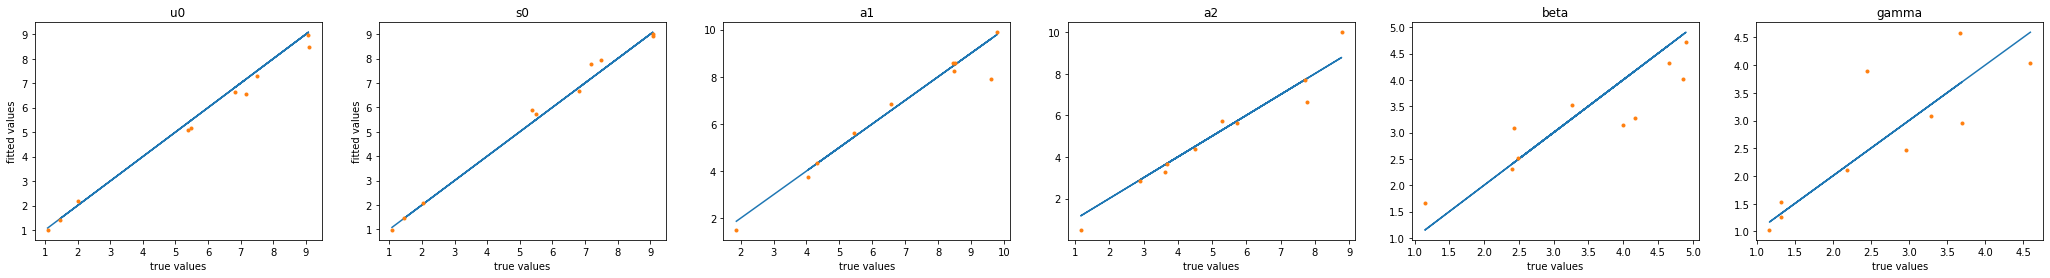

In [69]:
#%% update theta
weight=np.diag(v=[1]*n)
theta_hat=update_theta(X,weight,tau,parallel=True,n_threads=2,theta0=None)

plot_theta(theta,theta_hat,K)

## find posterior

In [70]:
m=1001
weight = update_weight(X,theta,tau,m)

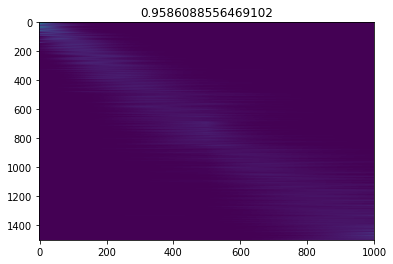

In [71]:
plot_t(weight, t)

## traj_EM

In [116]:
#%% generate data
np.random.seed(2022)
n = 1500
p = 15
u0 = np.random.uniform(0,10,size=p)
s0 = np.random.uniform(0,10,size=p)
a1 = np.random.uniform(0,10,size=p)
a2 = np.random.uniform(0,10,size=p)
beta = np.random.uniform(1,5,size=p)
gamma = np.random.uniform(1,5,size=p)

t = np.linspace(0, 1, n)

Tau=[0,0.5]
tau=(0,0.5,1)

K=len(tau)-1
theta=np.zeros((p,K+4))
theta[:,0]=a1
theta[:,1]=a2
theta[:,-3]=s0
theta[:,-4]=u0
theta[:,-1]=gamma
theta[:,-2]=beta

Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

%time theta_hat, weight = traj_EM(X, tau, m=101, epoch=20, parallel = True, n_threads = 2)

CPU times: user 2.44 s, sys: 1.08 s, total: 3.52 s
Wall time: 2min 18s


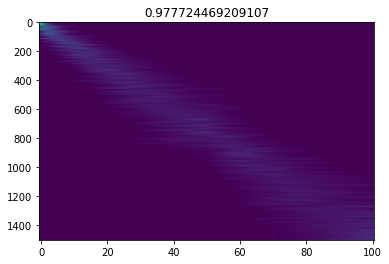

In [117]:
plot_t(weight,t)

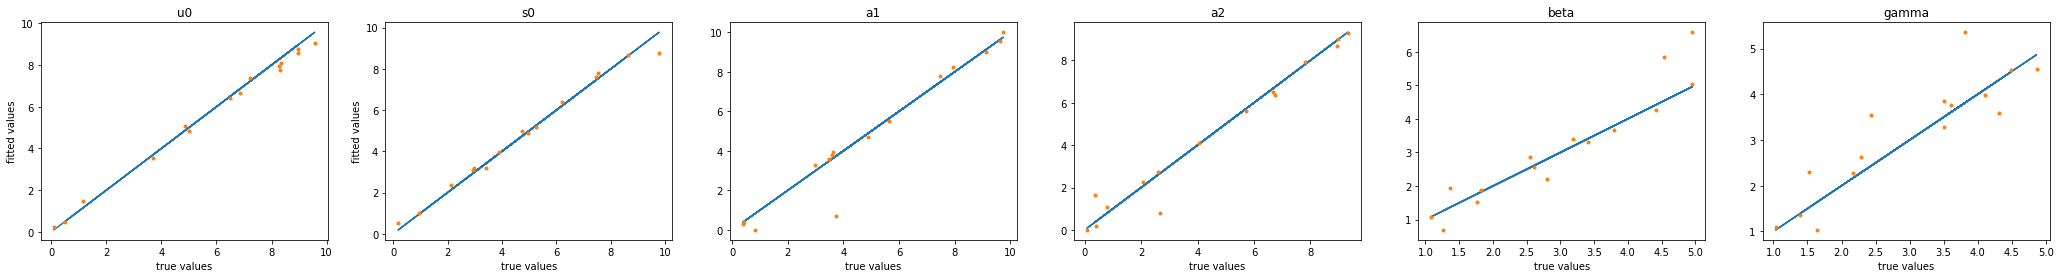

In [118]:
plot_theta(theta,theta_hat,K)

In [104]:
#%% generate data
np.random.seed(2022)
n = 1500
p = 50
u0 = np.random.uniform(0,10,size=p)
s0 = np.random.uniform(0,10,size=p)
a1 = np.random.uniform(0,10,size=p)
a2 = np.random.uniform(0,10,size=p)
beta = np.random.uniform(1,5,size=p)
gamma = np.random.uniform(1,5,size=p)

t = np.linspace(0, 1, n)

Tau=[0,0.5]
tau=(0,0.5,1)

K=len(tau)-1
theta=np.zeros((p,K+4))
theta[:,0]=a1
theta[:,1]=a2
theta[:,-3]=s0
theta[:,-4]=u0
theta[:,-1]=gamma
theta[:,-2]=beta

Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

%time theta_hat, weight = traj_EM(X, tau, m=101, epoch=10, parallel = True, n_threads = 2)

/content/EM_functions.py:72: RuntimeWarning: invalid value encountered in log
  logL = np.sum( weight[:,:,None] * (x[:,None,:] * np.log( eps + Y) - Y ) )
/content/EM_functions.py:72: RuntimeWarning: invalid value encountered in log
  logL = np.sum( weight[:,:,None] * (x[:,None,:] * np.log( eps + Y) - Y ) )
/content/EM_functions.py:72: RuntimeWarning: invalid value encountered in log
  logL = np.sum( weight[:,:,None] * (x[:,None,:] * np.log( eps + Y) - Y ) )
/content/EM_functions.py:72: RuntimeWarning: invalid value encountered in log
  logL = np.sum( weight[:,:,None] * (x[:,None,:] * np.log( eps + Y) - Y ) )


CPU times: user 2.86 s, sys: 707 ms, total: 3.57 s
Wall time: 4min


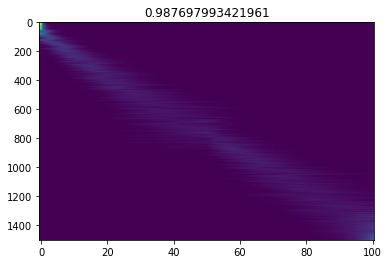

In [107]:
plot_t(weight,t)

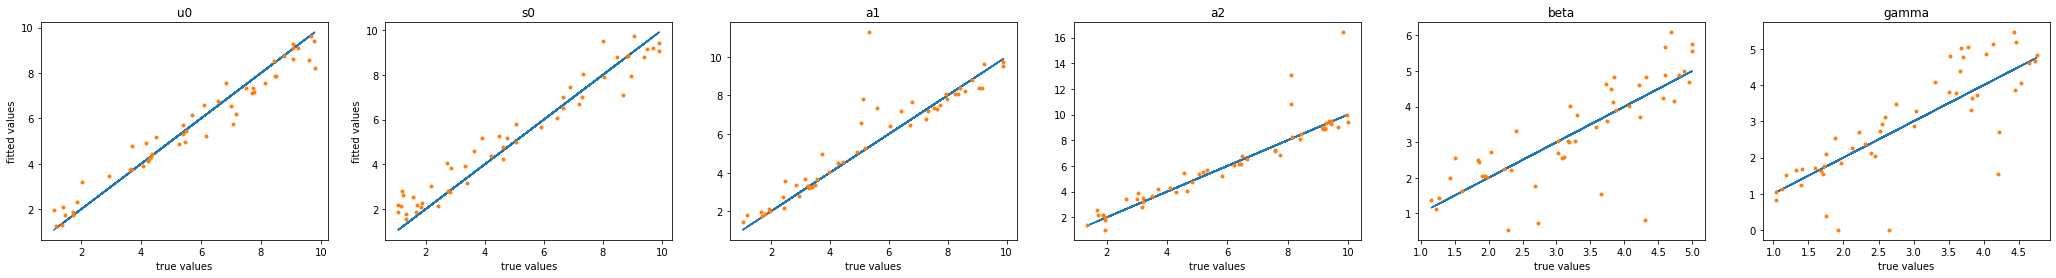

In [106]:
plot_theta(theta,theta_hat,K)

## Wrong tau

In [120]:
#%% generate data
np.random.seed(2022)
n = 1500
p = 15
u0 = np.random.uniform(1,10,size=p)
s0 = np.random.uniform(1,10,size=p)
a1 = np.random.uniform(1,10,size=p)
a2 = np.random.uniform(1,10,size=p)
beta = np.random.uniform(1,5,size=p)
gamma = np.random.uniform(1,5,size=p)

t = np.linspace(0, 1, n)

tau=(0,0.5,1)
tau_hat=(0,0.7,1)

K=2
theta=np.zeros((p,K+4))
theta[:,0]=a1
theta[:,1]=a2
theta[:,-4]=u0
theta[:,-3]=s0
theta[:,-2]=beta
theta[:,-1]=gamma

Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

m=101
%time theta_hat, weight = traj_EM(X, tau_hat, m=101, epoch=20, parallel = True, n_threads = 2)

CPU times: user 2.45 s, sys: 1.09 s, total: 3.54 s
Wall time: 2min 18s


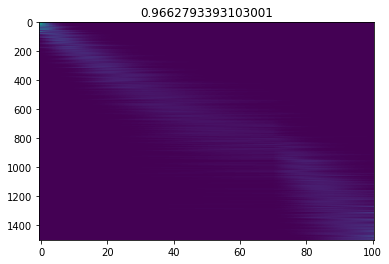

In [121]:
plot_t(weight,t)

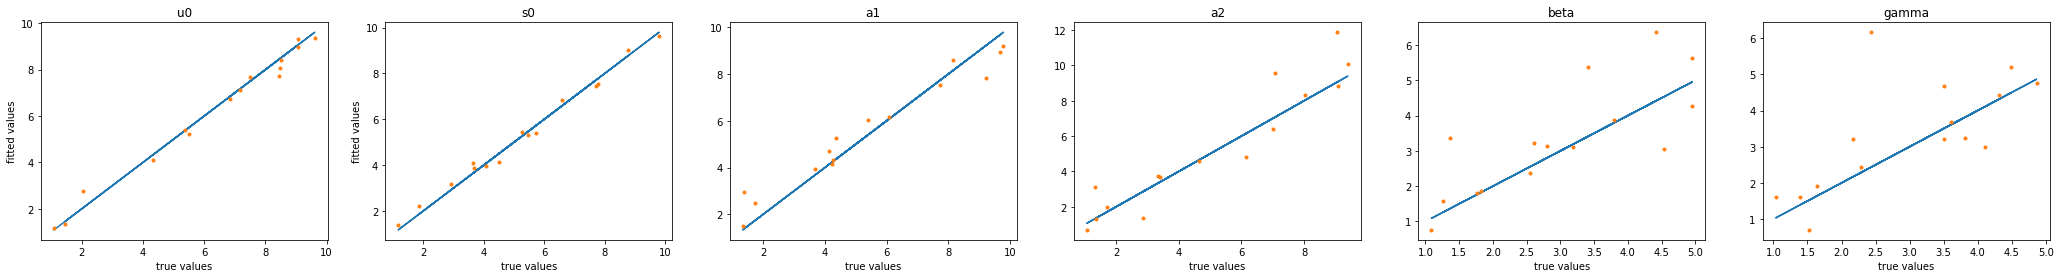

In [122]:
plot_theta(theta,theta_hat,K)

# Real data

In [123]:
!pip install -U scvelo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 196 kB 5.5 MB/s 
     |████████████████████████████████| 88 kB 6.8 MB/s 
     |████████████████████████████████| 96 kB 5.8 MB/s 
     |████████████████████████████████| 2.0 MB 45.2 MB/s 
     |████████████████████████████████| 11.2 MB 50.1 MB/s 
     |████████████████████████████████| 4.8 MB 39.0 MB/s 
     |████████████████████████████████| 930 kB 56.2 MB/s 
     |████████████████████████████████| 1.1 MB 43.9 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52040 sha256=a74b1922a321cd0f9cbddd056308fd88dd9f18d4dbeb01a25b9e451c8df20c91
  Stored in directory: /root/.cache/pip/wheels/48/36/9f/eb3377d4a7423b96105b6667d36c3faa49ee73b96d8cab80b3
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=45b710be44e0bbf9958ce2ddbd1952df039

In [1]:
import scvelo as scv

adata = scv.datasets.forebrain()
adata

  0%|          | 0.00/29.2M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 1720 × 32738
    obs: 'Clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [2]:
adata.var_names

Index(['FAM138A', 'RP11-34P13.7', 'RP11-34P13.8', 'AL627309.1',
       'RP11-34P13.14', 'AP006222.2', 'RP4-669L17.2', 'RP5-857K21.1',
       'RP5-857K21.3', 'RP5-857K21.4',
       ...
       'BPY2', 'DAZ2', 'AC016752.1', 'TTTY17B', 'TTTY4B', 'BPY2B', 'DAZ4',
       'CSPG4P1Y', 'CDY1', 'TTTY3'],
      dtype='object', name='Gene', length=32738)

## Inference with only marker genes

In [8]:
genes=["SOX2","SLC17A7","EOMES","CLU","FBXO32",
       "UNC5D","SEZ6","RBFOX1","DCX","GRIA3",
       "STMN2", "FAM64A","ELAVL4","RNASEH2B"]
idx=adata.var_names.isin(genes)
gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

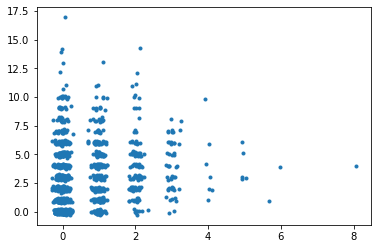

In [ ]:
j=0
plt.plot(X[:,j,0]+np.random.normal(scale=0.1,size=n),X[:,j,1]+np.random.normal(scale=0.1,size=n),'.');

### Two states 0.3

In [56]:
theta_hat, weight = traj_EM(X,tau=(0,0.3,1), m=101, epoch=20, parallel=True, n_threads=2)

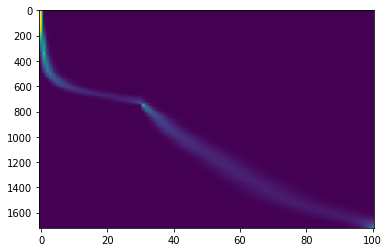

In [57]:
plot_t(weight)

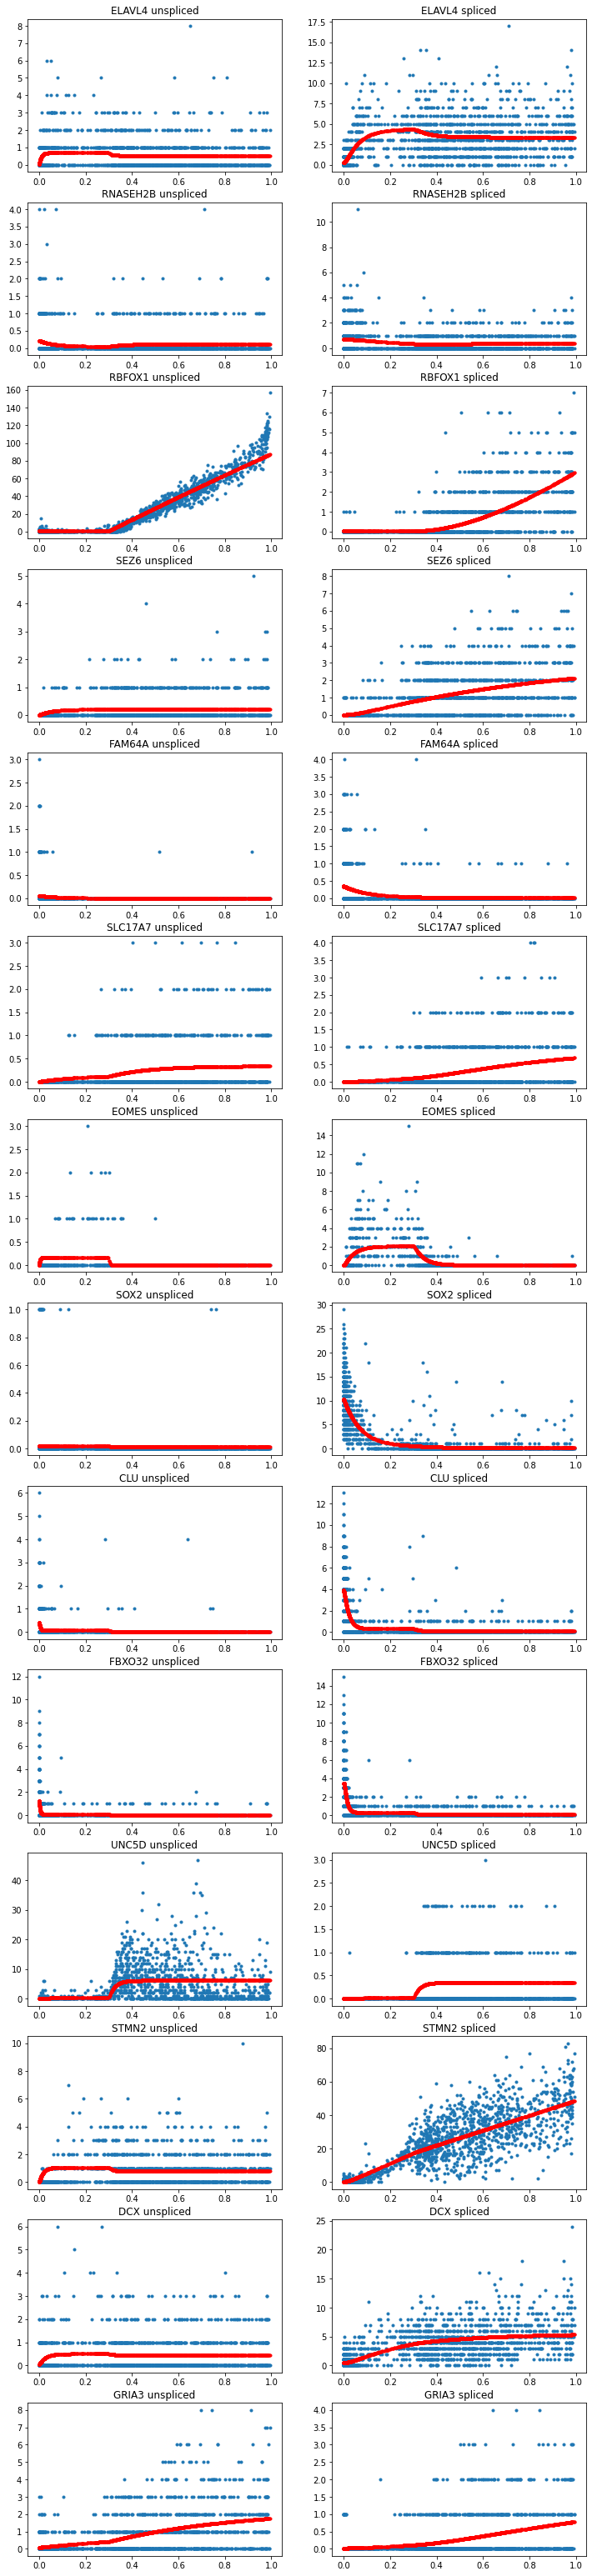

In [62]:
plot_y(theta_hat, weight, (0,0.3,1), gene_list)

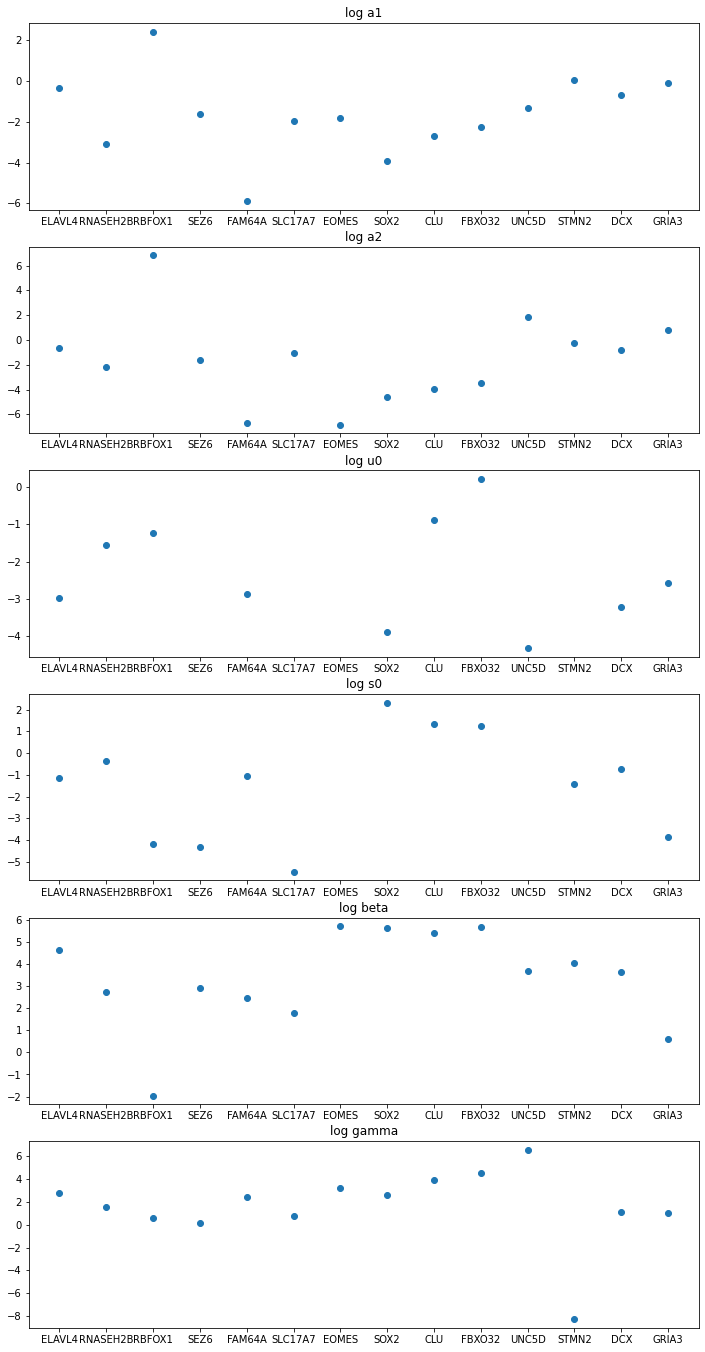

In [60]:
plot_theta_hat(theta_hat,2,gene_list)

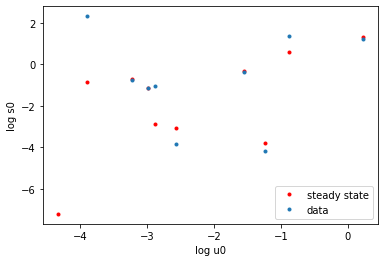

In [66]:
plt.plot(np.log(theta_hat[:,-4]),np.log(theta_hat[:,-4]*theta_hat[:,-2]/theta_hat[:,-1]),'r.',label="steady state");
plt.plot(np.log(theta_hat[:,-4]),np.log(theta_hat[:,-3]),'.',label="data");
plt.xlabel("log u0")
plt.ylabel("log s0")
plt.legend();

**Check cell size** 

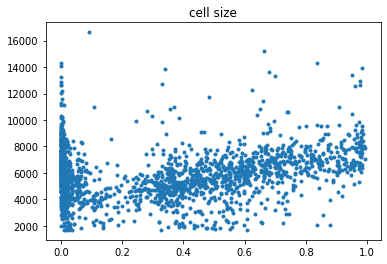

In [70]:
m=np.shape(weight)[1]
h=np.linspace(0,1,m)
t_hat=np.sum(weight*h[None,:],axis=1)
plt.plot(t_hat,np.sum(adata.layers["spliced"],axis=1),'.');
plt.title("cell size");

### Two states 0.5

In [71]:
theta_hat, weight = traj_EM(X,tau=(0,0.5,1), m=101, epoch=20, parallel=True, n_threads=2)

100%|██████████| 20/20 [04:44<00:00, 14.25s/it]


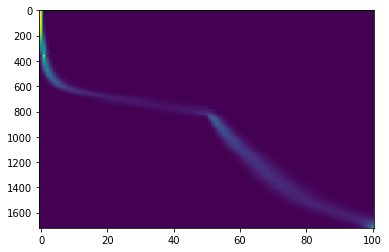

In [72]:
plot_t(weight)

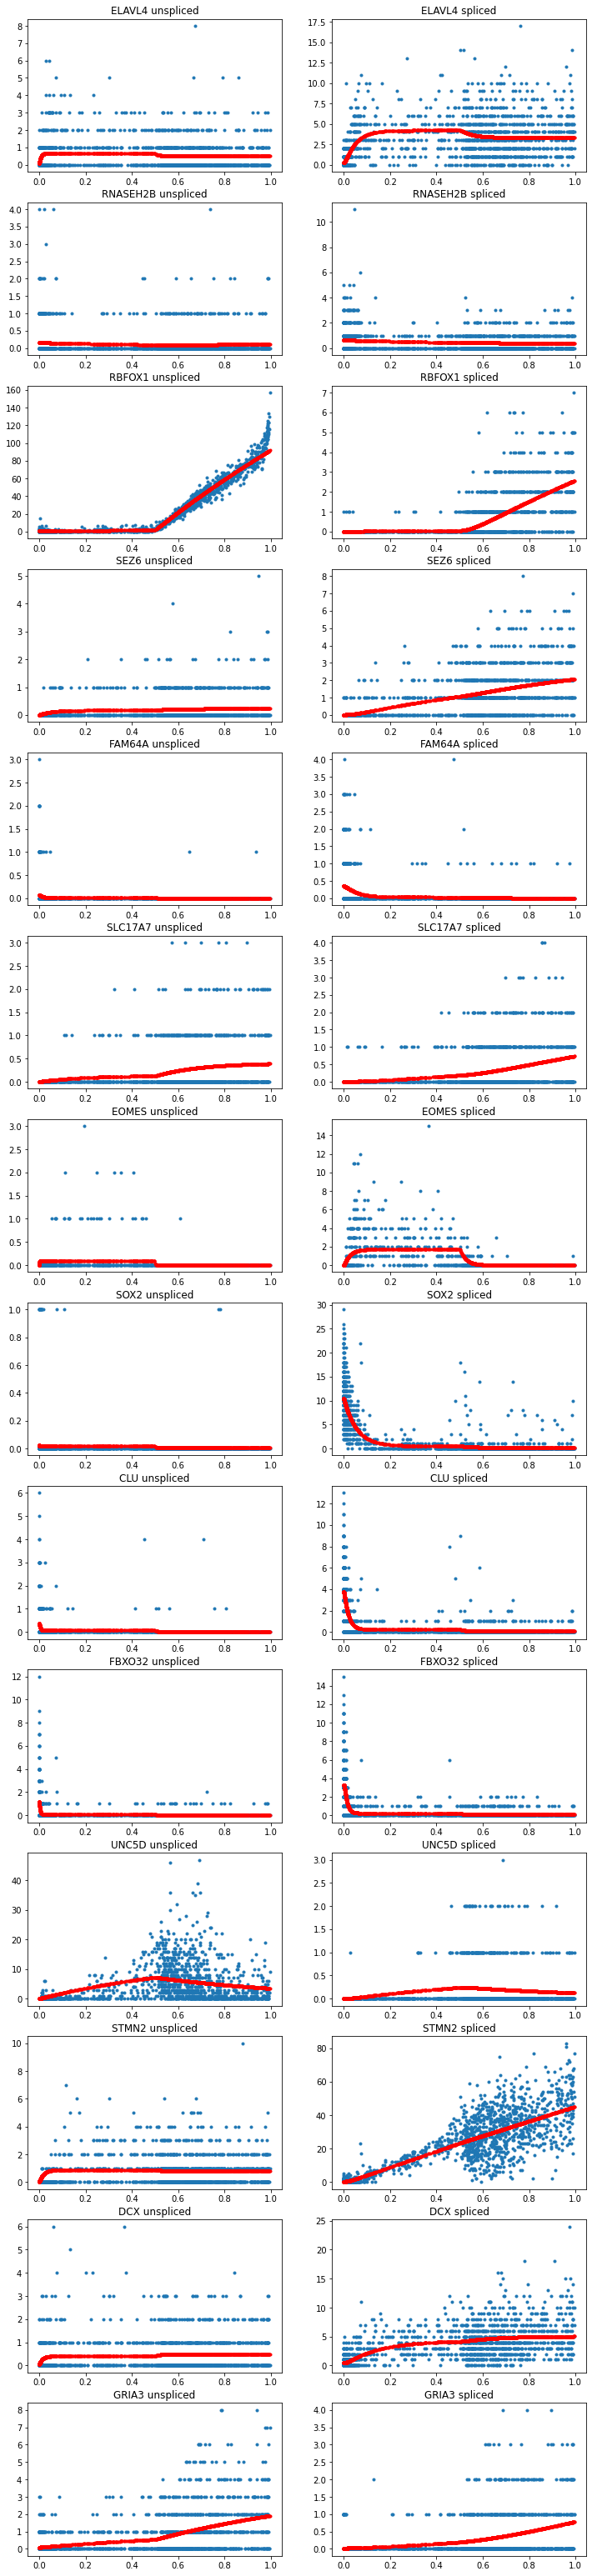

In [73]:
plot_y(theta_hat, weight, (0,0.5,1), gene_list)

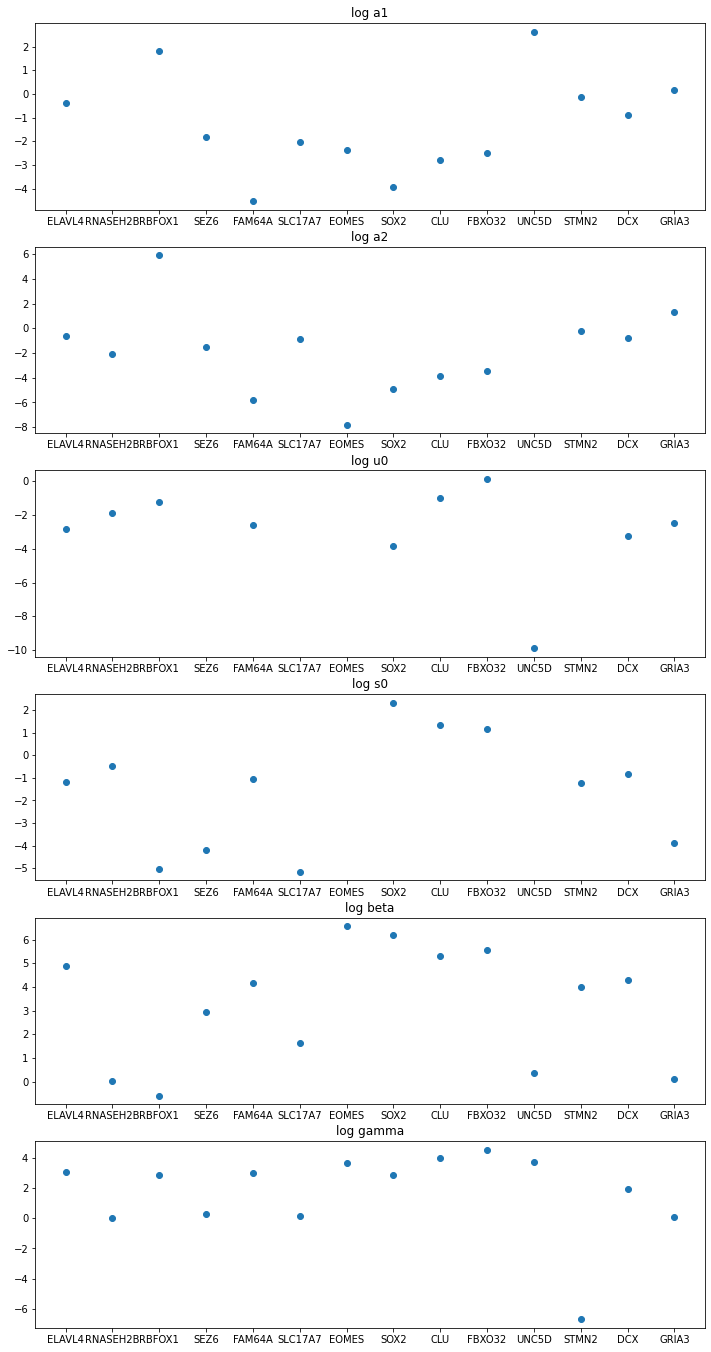

In [74]:
plot_theta_hat(theta_hat,2,gene_list)

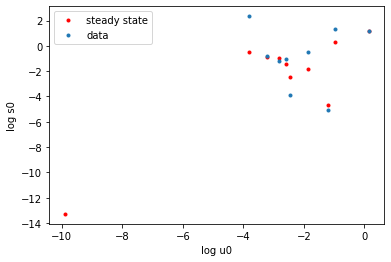

In [75]:
plt.plot(np.log(theta_hat[:,-4]),np.log(theta_hat[:,-4]*theta_hat[:,-2]/theta_hat[:,-1]),'r.',label="steady state");
plt.plot(np.log(theta_hat[:,-4]),np.log(theta_hat[:,-3]),'.',label="data");
plt.xlabel("log u0")
plt.ylabel("log s0")
plt.legend();

**Check cell size** 

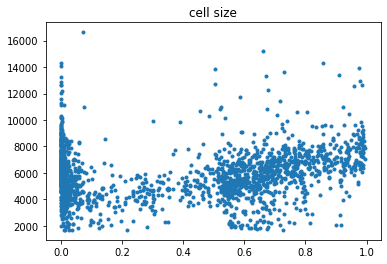

In [76]:
m=np.shape(weight)[1]
h=np.linspace(0,1,m)
t_hat=np.sum(weight*h[None,:],axis=1)
plt.plot(t_hat,np.sum(adata.layers["spliced"],axis=1),'.');
plt.title("cell size");